# Alpha Analysis

We'll try first to scale our weights to target volatility and see if we can improve the performance of the base strategy based on that. 

In [41]:
import polars as pl 
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from pathlib import Path
from sklearn.decomposition import PCA
COL_DATE='tradingDay'

In [39]:
script_dir = Path(Path.cwd()).parent
df = pl.read_parquet(script_dir / 'data' / 'synthetic_prices.parquet')
df = df.filter(pl.col('tradingDay') > datetime.date(2015,12,31))
df = df.group_by("tradingDay").first().sort("tradingDay")
df_ret = pl.read_parquet(script_dir / 'data' / 'df_ret.parquet')
df_w = pl.read_parquet(script_dir / 'data' / 'df_w.parquet')
df_w2 = pl.read_parquet(script_dir / 'data' / 'df_w2.parquet')
df_attr = pl.read_parquet(script_dir / 'data' / 'df_attr.parquet')
daily_pnl = pl.read_parquet(script_dir / 'data' / 'daily_pnl.parquet')
diag = pd.read_parquet(script_dir / 'data' / 'diag.parquet')
daily_xs = pl.read_parquet(script_dir / 'data' / 'daily_xs.parquet')

## Volatility Targetting

In [3]:
TARGET_VOL_ANN = 0.16
TRADING_DAYS = 252
TARGET_VOL_DAILY = TARGET_VOL_ANN / np.sqrt(TRADING_DAYS)

def vol_target_constant_annual(
    daily_pnl: pl.DataFrame,
    ret_col: str = "strategy_ret",
    date_col: str = "tradingDay",
    window: int = 20,            # 1-month realized vol
    min_periods: int = 10,       # avoid noisy early estimates
) -> pl.DataFrame:

    df = daily_pnl.sort(date_col)

    # 1) Realized vol estimate (daily)
    # Note: use shift(1) so today's position uses vol estimated through yesterday
    df = df.with_columns([
        pl.col(ret_col)
          .rolling_std(window_size=window, min_periods=min_periods)
          .shift(1)
          .alias("rv_daily"),
    ])

    # 2) Scale to target vol
    df = df.with_columns([
        (pl.lit(TARGET_VOL_DAILY) / pl.col("rv_daily")).alias("scale_raw"),
    ])

    # 3) Handle startup / missing vol (choose neutral scaling = 0 or 1)
    # Here: keep strategy off until vol is defined, then scale.
    df = df.with_columns([
        pl.when(pl.col("scale_raw").is_finite())
          .then(pl.col("scale_raw"))
          .otherwise(0.0)
          .alias("scale"),
    ])

    # 4) Apply scaling to returns
    df = df.with_columns([
        (pl.col(ret_col) * pl.col("scale")).alias("strategy_ret_vt"),
    ])

    return df

daily_pnl_vt = vol_target_constant_annual(daily_pnl, window=20, min_periods=10)
daily_pnl_vt.sample(15)

tradingDay,strategy_ret,rv_daily,scale_raw,scale,strategy_ret_vt
date,f64,f64,f64,f64,f64
2022-12-07,-0.000341,0.007731,1.303792,1.303792,-0.000445
2016-12-15,0.016483,0.006704,1.503358,1.503358,0.02478
2017-03-10,0.010956,0.018307,0.550552,0.550552,0.006032
2025-03-28,0.005409,0.008595,1.172611,1.172611,0.006343
2024-11-29,0.011488,0.009891,1.019026,1.019026,0.011706
…,…,…,…,…,…
2025-10-20,0.017532,0.009546,1.055832,1.055832,0.018511
2017-09-18,0.01657,0.009894,1.018669,1.018669,0.016879
2022-05-13,0.013537,0.009603,1.049547,1.049547,0.014207


In [4]:
vt_stats = daily_pnl_vt.select([
    (pl.col("strategy_ret_vt").std() * np.sqrt(252)).alias("realized_vol_ann_vt"),
    (pl.col('strategy_ret_vt').mean() * 252).alias("annualized_mean_ret_vt"),
    (pl.col("strategy_ret").std() * np.sqrt(252)).alias("realized_vol_ann"),
    (pl.col('strategy_ret').mean() * 252).alias("annualized_mean_ret"),
    pl.col("scale").mean().alias("avg_scale"),
    pl.col("scale").max().alias("max_scale"),
])

vt_stats

realized_vol_ann_vt,annualized_mean_ret_vt,realized_vol_ann,annualized_mean_ret,avg_scale,max_scale
f64,f64,f64,f64,f64,f64
0.185807,0.259444,0.202509,0.314152,1.081035,2.356579


In [5]:
0.26/0.186

1.3978494623655915

### Conclusions

Not a great idea.

## Dissecting the Trading Alpha
### Carry

In [6]:
df_sig = (
    daily_pnl.join(df_attr.select(["tradingDay", "port_carry"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns(
        pl.col("strategy_ret").shift(-1).alias("forward_ret")
    )
    .drop('strategy_ret')
    .rename({'port_carry':'carry_signal'})
    .drop_nulls(["carry_signal", "forward_ret"])
)
df_sig.head()

tradingDay,carry_signal,forward_ret
date,f64,f64
2016-05-13,0.001616,0.012133
2016-05-16,0.001429,0.00218
2016-05-17,0.001541,0.00669
2016-05-18,0.001453,0.007617
2016-05-19,0.001547,-0.003219


In [7]:
df_sig = df_sig.with_columns(
    pl.col("carry_signal")
      .qcut(10, labels=[f"D{i+1}" for i in range(10)])
      .alias("carry_decile")
)

In [8]:
carry_decile_stats = (
    df_sig
    .group_by("carry_decile")
    .agg([
        pl.len().alias("n_days"),

        # forward returns
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),

        # tail diagnostics
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252))
            .alias("sharpe_ann"),
        (pl.col("mean_daily") * 252)
            .alias("mean_ann"),
    ])
    .sort("carry_decile")
)

carry_decile_stats

carry_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",240,0.004687,0.020538,-0.01736,-0.041733,3.622749,1.18114
"""D2""",240,0.00011,0.015315,-0.017479,-0.03118,0.114011,0.027718
"""D3""",240,0.000413,0.012871,-0.015779,-0.046604,0.508992,0.103997
"""D4""",240,0.001473,0.01035,-0.012867,-0.029418,2.259446,0.371214
"""D5""",240,0.000947,0.010138,-0.015051,-0.02449,1.483135,0.238693
"""D6""",240,0.001077,0.009457,-0.012515,-0.021833,1.807547,0.271361
"""D7""",240,0.00159,0.011231,-0.013775,-0.031647,2.246976,0.400604
"""D8""",240,0.000764,0.010468,-0.014219,-0.040515,1.158602,0.192537
"""D9""",240,0.00042,0.010779,-0.014573,-0.02908,0.617889,0.105728


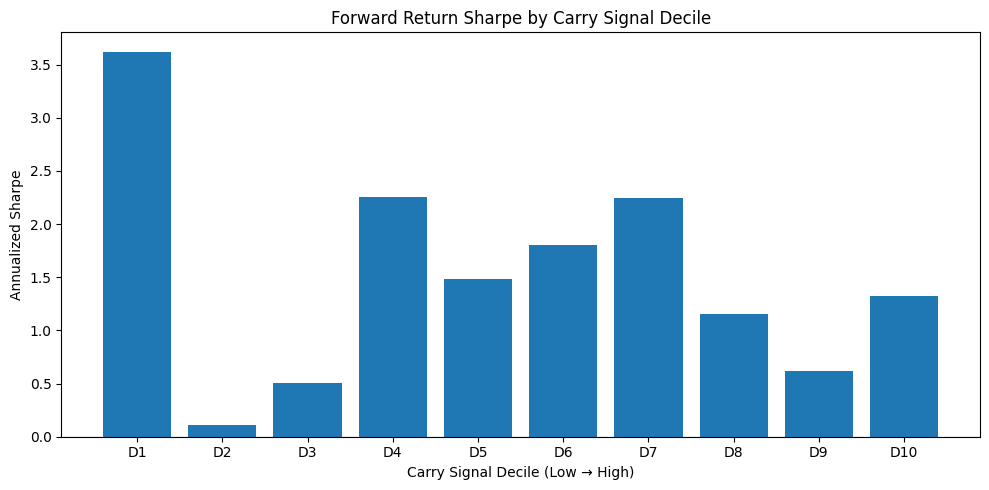

In [11]:
plot_df = carry_decile_stats.to_pandas()
plot_df["decile"] = plot_df["carry_decile"].astype(str)
plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title("Forward Return Sharpe by Carry Signal Decile")
plt.xlabel("Carry Signal Decile (Low → High)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

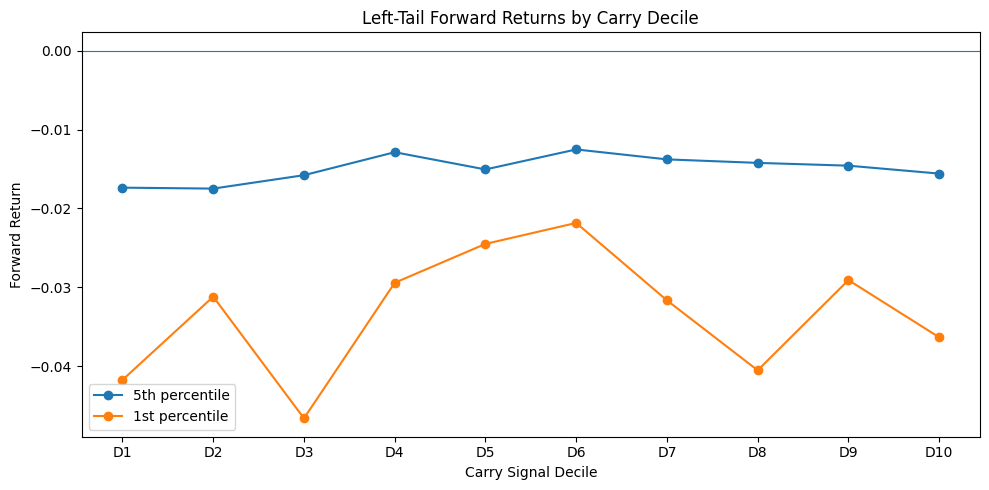

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title("Left-Tail Forward Returns by Carry Decile")
plt.xlabel("Carry Signal Decile")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()


Carry explains returns mechanically, but does not explain when the strategy should be large. The best risk-adjusted performance occurs in low-to-moderate carry environments, suggesting that jump risk, curve stability, or volatility of carry itself dominates sizing decisions.

### Change in Carry

In [12]:
# Signal at t, realized return t->t+1
df_sig_dcarry = (
    daily_pnl
    .join(df_attr.select(["tradingDay", "port_carry"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns([
        pl.col("port_carry").diff().alias("d_carry"),
        pl.col("strategy_ret").shift(-1).alias("forward_ret"),
    ])
    .drop_nulls(["d_carry", "forward_ret"])
    .with_columns(
        pl.col("d_carry")
          .qcut(10, labels=[f"D{i+1}" for i in range(10)])
          .alias("dcarry_decile")
    )
)

dcarry_decile_stats = (
    df_sig_dcarry
    .group_by("dcarry_decile")
    .agg([
        pl.len().alias("n_days"),
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
        (pl.col("mean_daily") * 252).alias("mean_ann"),
    ])
    .sort("dcarry_decile")
)

dcarry_decile_stats

dcarry_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",240,0.00122,0.015775,-0.019928,-0.043533,1.227254,0.307321
"""D2""",240,0.002158,0.013811,-0.015538,-0.040647,2.480336,0.543815
"""D3""",240,0.001668,0.01026,-0.012979,-0.023593,2.58148,0.420442
"""D4""",240,0.001715,0.009325,-0.012374,-0.023938,2.919995,0.432246
"""D5""",240,0.000998,0.010376,-0.011768,-0.01853,1.526773,0.251474
"""D6""",239,0.001311,0.017113,-0.014219,-0.03118,1.216325,0.330432
"""D7""",240,0.001224,0.009358,-0.012721,-0.022874,2.075917,0.308387
"""D8""",240,0.000074,0.012097,-0.021228,-0.036328,0.097617,0.018746
"""D9""",240,0.001447,0.010201,-0.014212,-0.020192,2.251321,0.364574


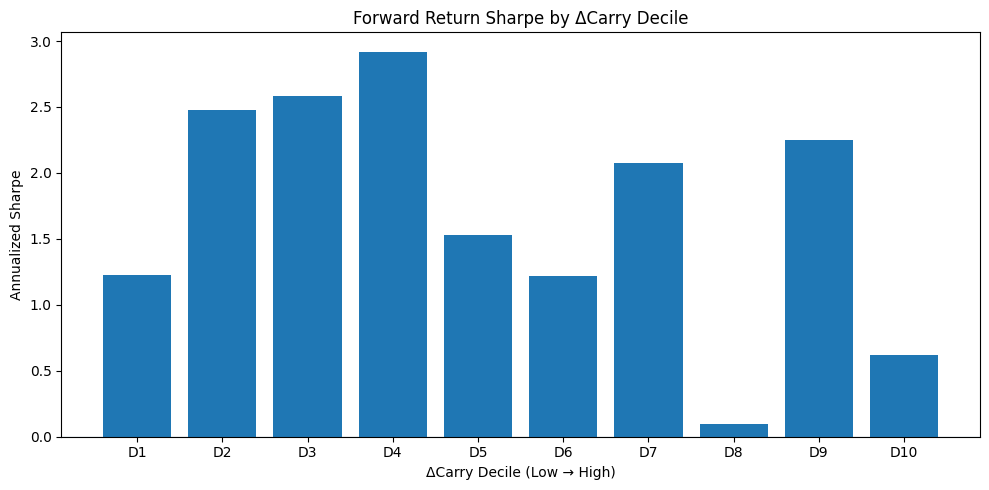

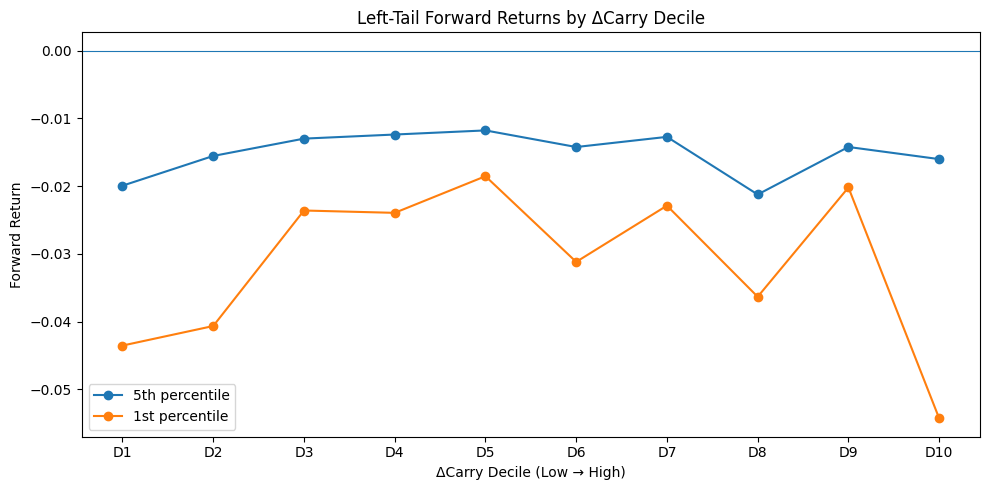

In [13]:
plot_df = dcarry_decile_stats.to_pandas()
plot_df["decile"] = plot_df["dcarry_decile"].astype(str)

# A) Sharpe by Δcarry decile
plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title("Forward Return Sharpe by ΔCarry Decile")
plt.xlabel("ΔCarry Decile (Low → High)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

# B) Left tail by Δcarry decile
plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title("Left-Tail Forward Returns by ΔCarry Decile")
plt.xlabel("ΔCarry Decile (Low → High)")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()


1. Δcarry is informative
2. The relationship is non-linear
3. Extremes are danger zones
4. Middle regimes are where the edge lives
5. Dynamic sizing should be convex and capped, not proportional

### Standard Deviation of Carry (Carry Dispersion)

In [44]:
CARRY_VOL_WIN = 21

df_sig_cvol = (
    daily_pnl
    .join(df_attr.select(["tradingDay", "port_carry"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns([
        pl.col("port_carry").rolling_std(window_size=CARRY_VOL_WIN).alias("carry_vol"),
        pl.col("strategy_ret").shift(-1).alias("forward_ret"),
    ])
    .drop_nulls(["carry_vol", "forward_ret"])
    .with_columns(
        pl.col("carry_vol")
          .qcut(10, labels=[f"D{i+1}" for i in range(10)])
          .alias("carryvol_decile")
    )
)
df_sig_cvol.write_parquet(script_dir / 'data' / 'df_sig_cvol.parquet')

carryvol_decile_stats = (
    df_sig_cvol
    .group_by("carryvol_decile")
    .agg([
        pl.len().alias("n_days"),
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
        (pl.col("mean_daily") * 252).alias("mean_ann"),
    ])
    .sort("carryvol_decile")
)

carryvol_decile_stats

carryvol_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",238,0.00029,0.008896,-0.013228,-0.018528,0.517315,0.073058
"""D2""",238,-0.000263,0.01063,-0.013286,-0.032328,-0.392933,-0.066305
"""D3""",238,0.001074,0.011769,-0.016483,-0.032198,1.448509,0.270616
"""D4""",238,-0.000217,0.011806,-0.01605,-0.050245,-0.292063,-0.054735
"""D5""",238,0.000921,0.010536,-0.015192,-0.040647,1.388004,0.232159
"""D6""",238,0.000822,0.012358,-0.015388,-0.046595,1.055542,0.207075
"""D7""",238,0.002318,0.011033,-0.014525,-0.022899,3.335932,0.584244
"""D8""",238,0.001818,0.010492,-0.015556,-0.02449,2.750438,0.4581
"""D9""",238,0.000946,0.009403,-0.013952,-0.020086,1.597021,0.238389


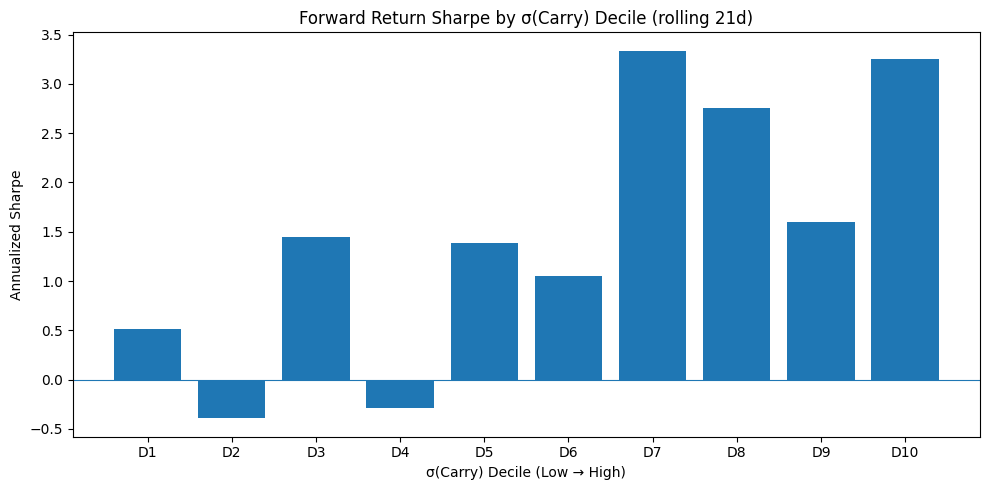

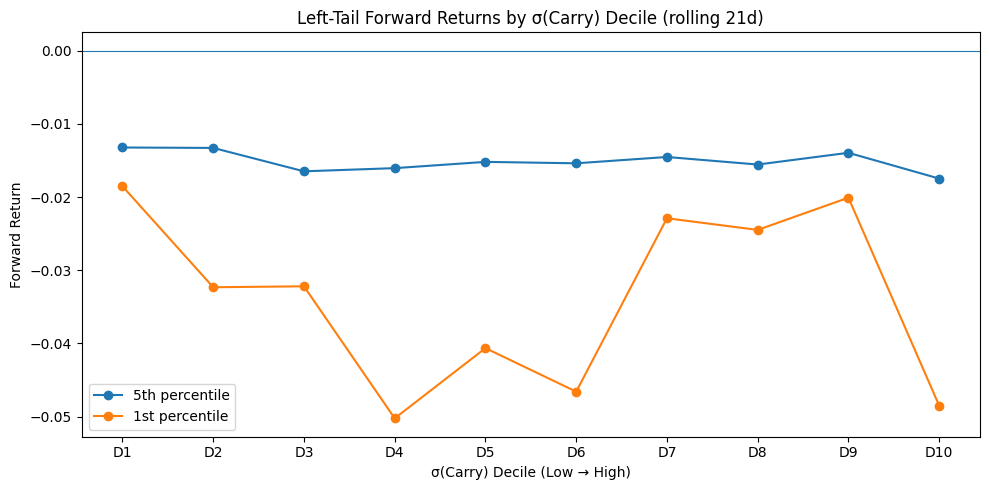

In [15]:
plot_df = carryvol_decile_stats.to_pandas()
plot_df["decile"] = plot_df["carryvol_decile"].astype(str)

# A) Sharpe by carry-vol decile
plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title(f"Forward Return Sharpe by σ(Carry) Decile (rolling {CARRY_VOL_WIN}d)")
plt.xlabel("σ(Carry) Decile (Low → High)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

# B) Left tail by carry-vol decile
plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title(f"Left-Tail Forward Returns by σ(Carry) Decile (rolling {CARRY_VOL_WIN}d)")
plt.xlabel("σ(Carry) Decile (Low → High)")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()

The strategy makes money when carry is moving, not when it is calm.

That is consistent with:

* Roll-down acceleration
* Term structure re-shaping
* PCA residual curvature being actively harvested


When σ(carry) is high:
* The curve is actively reshaping
* PCA-neutralization removes level shocks
* What remains is curvature + roll-down acceleration
* You are effectively long term-structure convexity

When σ(carry) is low:
* Carry is static
* The trade degenerates into weak drift
* Residual shocks dominate

This explains:
* Why vol targeting diluted returns
* Why constant sizing underutilizes high-edge regimes

### Front Slope Analysis

In [18]:
df_sig_fslope = (
    daily_pnl
    .join(df_w2.select(["tradingDay", "px_30d", "px_60d"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns([
        (pl.col("px_60d") - pl.col("px_30d")).alias("front_slope"),
        pl.col("strategy_ret").shift(-1).alias("forward_ret"),
    ])
    .drop_nulls(["front_slope", "forward_ret"])
    .with_columns(
        pl.col("front_slope")
          .qcut(10, labels=[f"D{i+1}" for i in range(10)])
          .alias("frontslope_decile")
    )
)

frontslope_decile_stats = (
    df_sig_fslope
    .group_by("frontslope_decile")
    .agg([
        pl.len().alias("n_days"),
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
        (pl.col("mean_daily") * 252).alias("mean_ann"),
    ])
    .sort("frontslope_decile")
)

frontslope_decile_stats


frontslope_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",240,0.004734,0.023244,-0.019379,-0.048503,3.233324,1.193034
"""D2""",240,0.0009,0.011515,-0.016288,-0.030251,1.240105,0.226691
"""D3""",240,-0.000182,0.013395,-0.017636,-0.054278,-0.215814,-0.04589
"""D4""",240,0.001129,0.00987,-0.015254,-0.026385,1.81652,0.284605
"""D5""",240,0.001591,0.009128,-0.011723,-0.017474,2.767093,0.400976
"""D6""",240,0.001083,0.009865,-0.012515,-0.019928,1.742062,0.272823
"""D7""",240,0.000467,0.011324,-0.017382,-0.040647,0.655182,0.117776
"""D8""",240,0.000605,0.01051,-0.014525,-0.033361,0.9138,0.152458
"""D9""",240,0.001646,0.009799,-0.013286,-0.023593,2.665834,0.414691


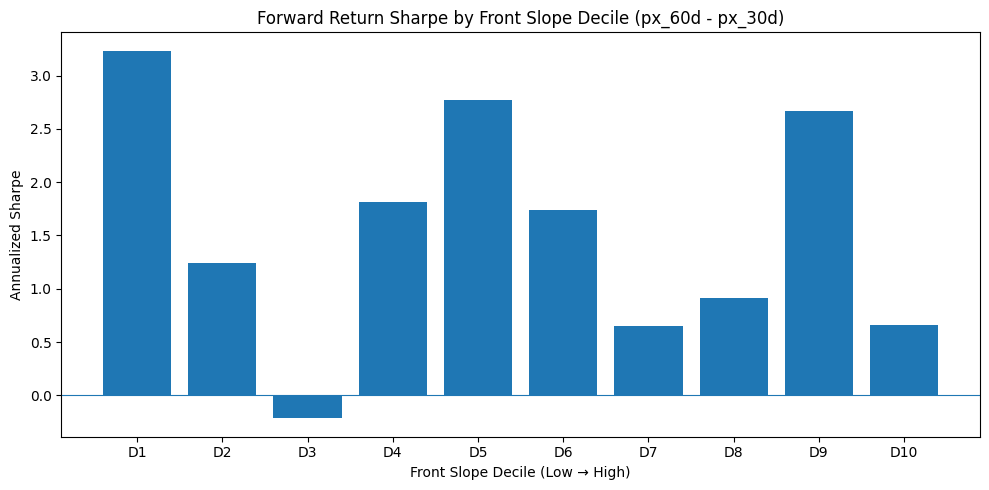

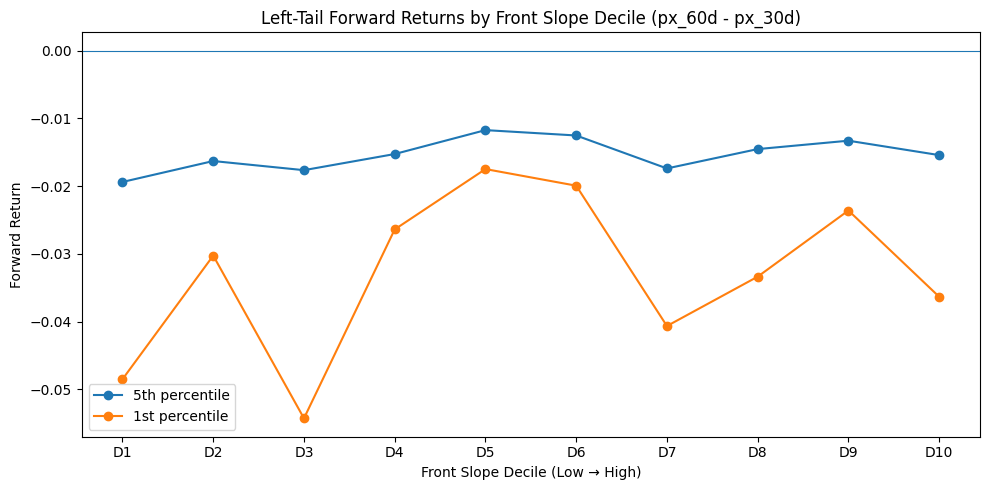

In [19]:
plot_df = frontslope_decile_stats.to_pandas()
plot_df["decile"] = plot_df["frontslope_decile"].astype(str)

# A) Sharpe by front-slope decile
plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title("Forward Return Sharpe by Front Slope Decile (px_60d - px_30d)")
plt.xlabel("Front Slope Decile (Low → High)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

# B) Left tail by front-slope decile
plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title("Left-Tail Forward Returns by Front Slope Decile (px_60d - px_30d)")
plt.xlabel("Front Slope Decile (Low → High)")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()


Front slope is not a sizing knob, but it is a gating variable:
* It tells you when your Sharpe is real
* It tells you when your tails are unacceptable
* It explains why constant-vol scaling washed out your edge

### Back Slope Analysis

In [20]:
df_sig_bslope = (
    daily_pnl
    .join(df_w2.select(["tradingDay", "px_30d", "px_180d"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns([
        (pl.col("px_180d") - pl.col("px_30d")).alias("back_slope"),
        pl.col("strategy_ret").shift(-1).alias("forward_ret"),
    ])
    .drop_nulls(["back_slope", "forward_ret"])
    .with_columns(
        pl.col("back_slope")
          .qcut(10, labels=[f"D{i+1}" for i in range(10)])
          .alias("backslope_decile")
    )
)

backslope_decile_stats = (
    df_sig_bslope
    .group_by("backslope_decile")
    .agg([
        pl.len().alias("n_days"),
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
        (pl.col("mean_daily") * 252).alias("mean_ann"),
    ])
    .sort("backslope_decile")
)

backslope_decile_stats

backslope_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",240,0.004533,0.024682,-0.023506,-0.073033,2.915166,1.142195
"""D2""",240,0.00176,0.010913,-0.01125,-0.021849,2.560044,0.443513
"""D3""",240,0.001909,0.010584,-0.015144,-0.02449,2.862999,0.48101
"""D4""",240,0.000685,0.011585,-0.021228,-0.040647,0.938847,0.172653
"""D5""",240,0.002576,0.011394,-0.011707,-0.020086,3.588726,0.649113
"""D6""",240,-0.000056,0.008954,-0.013573,-0.022899,-0.0994,-0.014129
"""D7""",240,0.001761,0.01012,-0.012839,-0.032198,2.762119,0.443747
"""D8""",240,0.000333,0.010273,-0.014511,-0.023593,0.513985,0.08382
"""D9""",240,-0.001109,0.010005,-0.015679,-0.02908,-1.760343,-0.279594


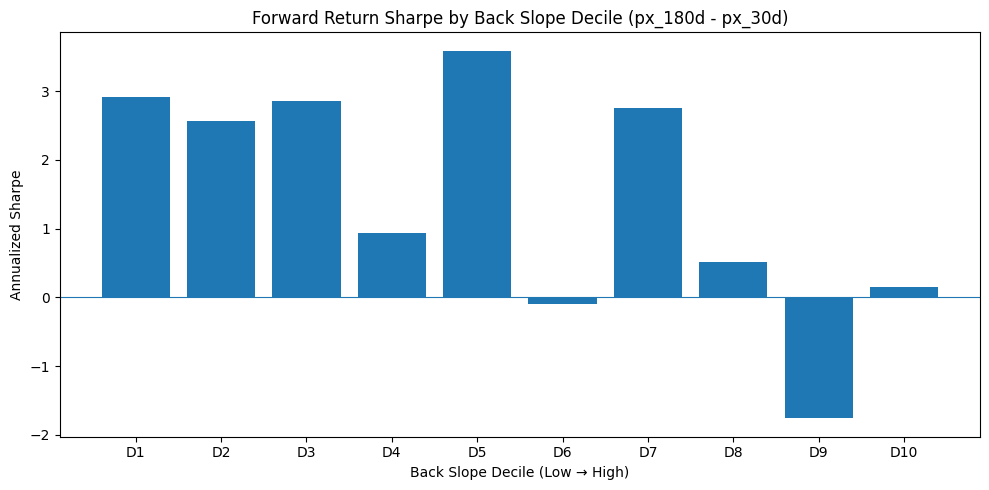

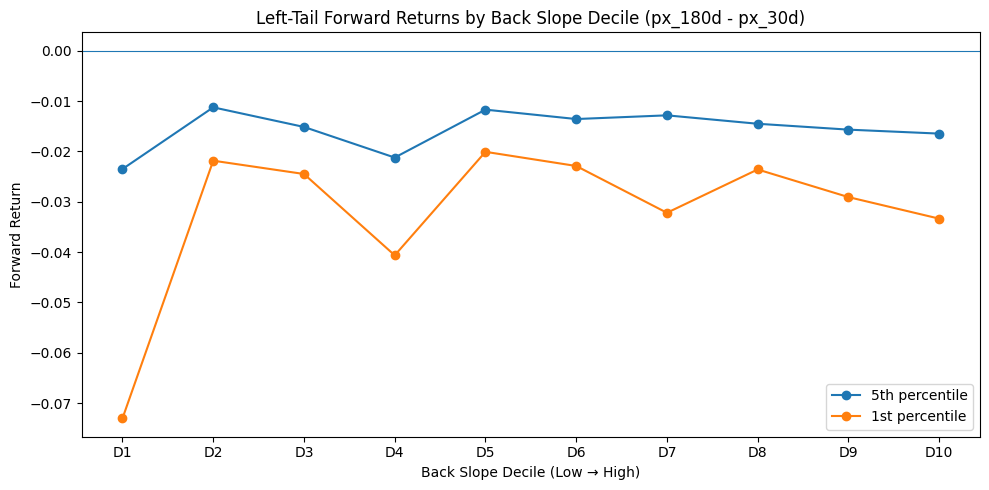

In [21]:
plot_df = backslope_decile_stats.to_pandas()
plot_df["decile"] = plot_df["backslope_decile"].astype(str)

# A) Sharpe by front-slope decile
plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title("Forward Return Sharpe by Back Slope Decile (px_180d - px_30d)")
plt.xlabel("Back Slope Decile (Low → High)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

# B) Left tail by front-slope decile
plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title("Left-Tail Forward Returns by Back Slope Decile (px_180d - px_30d)")
plt.xlabel("Back Slope Decile (Low → High)")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()

From this table alone, we now know:

* There exist states where expected return is negative
* There exist states where expected return is very high
* These states are observable ex ante
* Volatility is not the conditioning variable — term structure is

This is the first signal that legitimately supports state-dependent capital allocation.

### Curvature Analysis

In [22]:
df_sig_curv = (
    daily_pnl
    .join(df_w2.select(["tradingDay", "px_30d", "px_90d", "px_180d"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns([
        (pl.col("px_30d") - 2.0 * pl.col("px_90d") + pl.col("px_180d")).alias("curvature"),
        pl.col("strategy_ret").shift(-1).alias("forward_ret"),
    ])
    .drop_nulls(["curvature", "forward_ret"])
    .with_columns(
        pl.col("curvature").qcut(10, labels=[f"D{i+1}" for i in range(10)]).alias("curv_decile")
    )
)


curv_decile_stats = (
    df_sig_curv
    .group_by("curv_decile")
    .agg([
        pl.len().alias("n_days"),
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
        (pl.col("mean_daily") * 252).alias("mean_ann"),
    ])
    .sort("curv_decile")
)

curv_decile_stats

curv_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",240,0.001297,0.017934,-0.016955,-0.073033,1.147901,0.326799
"""D2""",240,0.001258,0.010589,-0.013162,-0.032328,1.885295,0.316914
"""D3""",240,0.002404,0.010411,-0.011259,-0.040515,3.665044,0.605722
"""D4""",240,0.001144,0.010981,-0.013573,-0.032198,1.653142,0.288168
"""D5""",240,0.001204,0.010498,-0.015679,-0.028503,1.820317,0.303344
"""D6""",240,0.000224,0.010505,-0.016914,-0.03116,0.339086,0.056549
"""D7""",240,-0.000388,0.01083,-0.015556,-0.035836,-0.56909,-0.097841
"""D8""",240,0.000298,0.010679,-0.01408,-0.034746,0.44265,0.075037
"""D9""",240,0.000986,0.010483,-0.015192,-0.020086,1.49368,0.248569


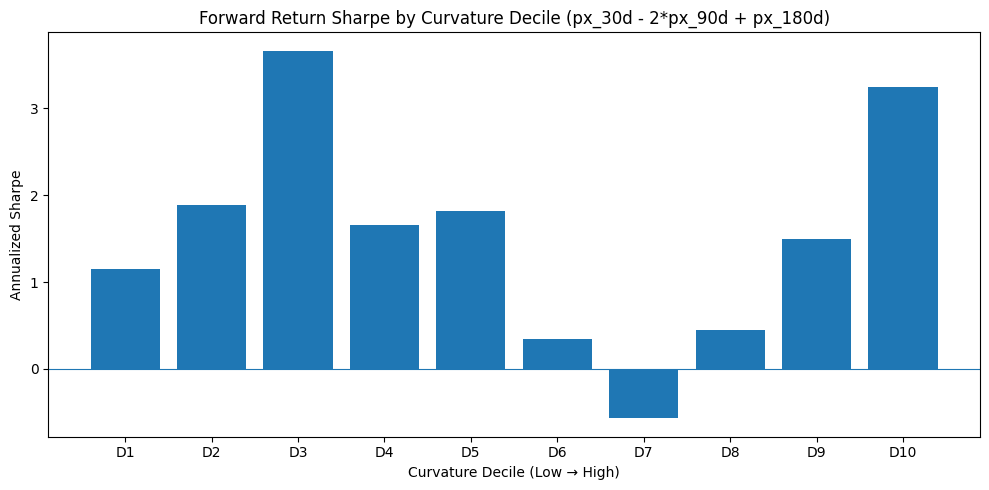

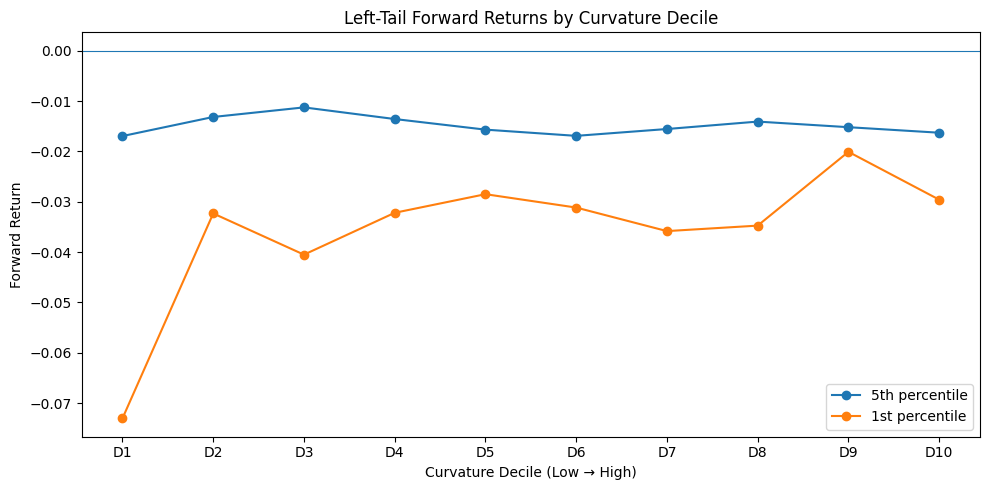

In [23]:
plot_df = curv_decile_stats.to_pandas()
plot_df["decile"] = plot_df["curv_decile"].astype(str)

plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title("Forward Return Sharpe by Curvature Decile (px_30d - 2*px_90d + px_180d)")
plt.xlabel("Curvature Decile (Low → High)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title("Left-Tail Forward Returns by Curvature Decile")
plt.xlabel("Curvature Decile (Low → High)")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()

This tells me curvature is not a linear risk-on / risk-off variable. It’s regime-defining, not direction-defining.

The strongest buckets are:

* Low–moderate curvature (D3)
* Very high curvature (D10)

The weakest bucket:
* Mid-to-high curvature (D7)

This suggests:
* The strategy benefits when the curve is either:
*I transitioning into a convex shape (early stress / normalization), or
* extremely convex (post-shock or deep stress regimes)

It struggles in unstable middle regimes where curvature exists but is not decisive

### VIX Levels and Change of VIX

In [45]:
df_sig_vix = (
    daily_pnl
    .join(df_w2.select(["tradingDay", "VIX"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns(
        pl.col("strategy_ret").shift(-1).alias("forward_ret")
    )
    .drop_nulls(["VIX", "forward_ret"])
    .with_columns(
        pl.col("VIX")
        .qcut(10, labels=[f"D{i+1}" for i in range(10)])
        .alias("vix_decile")
    )
)
df_sig_vix.write_parquet(script_dir / 'data' / 'df_sig_vix.parquet')
vix_decile_stats = (
    df_sig_vix
    .group_by("vix_decile")
    .agg([
        pl.len().alias("n_days"),
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
        (pl.col("mean_daily") * 252).alias("mean_ann"),
    ])
    .sort("vix_decile")
)

vix_decile_stats


vix_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",240,-0.000636,0.010523,-0.014511,-0.03116,-0.958837,-0.160166
"""D2""",240,0.000797,0.009716,-0.013093,-0.023938,1.301427,0.200722
"""D3""",240,0.000801,0.010251,-0.012721,-0.026385,1.241002,0.201955
"""D4""",241,-0.000299,0.01161,-0.01872,-0.040515,-0.408942,-0.075368
"""D5""",239,0.000775,0.009746,-0.01629,-0.029418,1.261517,0.195175
"""D6""",240,0.002123,0.010975,-0.011749,-0.034746,3.07035,0.53493
"""D7""",240,0.001192,0.011427,-0.016955,-0.023044,1.655721,0.300342
"""D8""",240,0.001176,0.009755,-0.013659,-0.022811,1.91399,0.296383
"""D9""",240,0.001709,0.01346,-0.015018,-0.044612,2.014935,0.430548


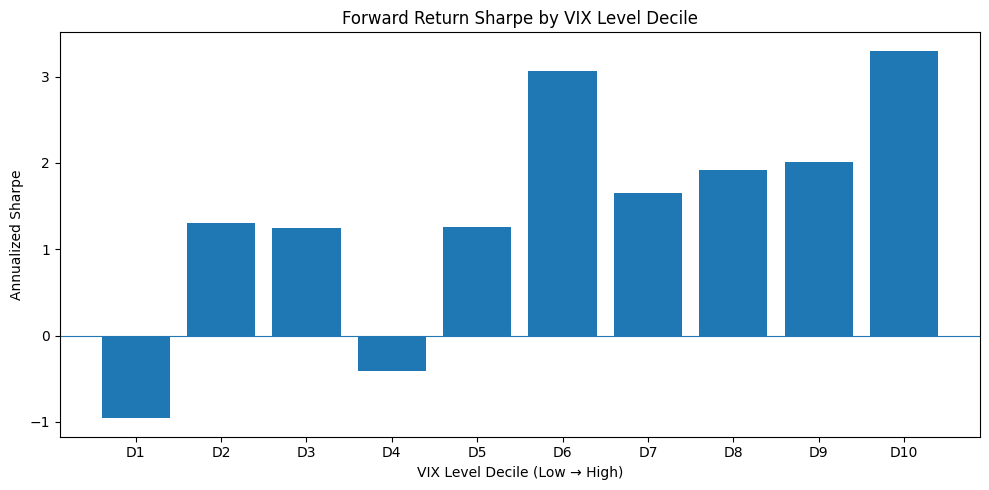

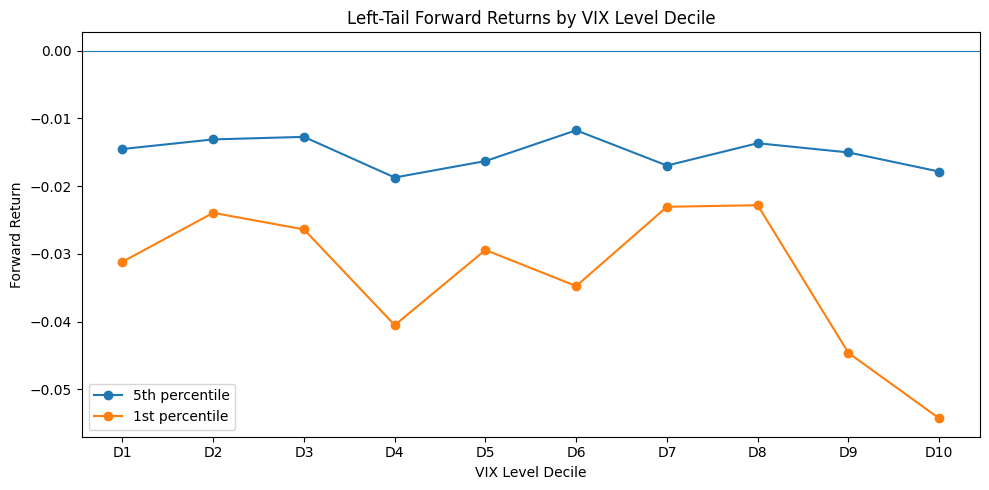

In [25]:
plot_df = vix_decile_stats.to_pandas()
plot_df["decile"] = plot_df["vix_decile"].astype(str)
plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title("Forward Return Sharpe by VIX Level Decile")
plt.xlabel("VIX Level Decile (Low → High)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title("Left-Tail Forward Returns by VIX Level Decile")
plt.xlabel("VIX Level Decile")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()

* This strategy does not work in low-vol regimes
* It is structurally dependent on some amount of volatility
* High VIX improves expectancy, but also increases crash sensitivity

Therefore:
* VIX level is a binary viability filter, not a convex signal

Conclusion
* VIX level should gate whether I trade, not how aggressively I scale past a point.

In [26]:
df_sig_dvix = (
    daily_pnl
    .join(df_w2.select(["tradingDay", "VIX"]), on="tradingDay", how="left")
    .sort("tradingDay")
    .with_columns([
        pl.col("VIX").diff().alias("dVIX"),
        pl.col("strategy_ret").shift(-1).alias("forward_ret"),
    ])
    .drop_nulls(["dVIX", "forward_ret"])
    .with_columns(
        pl.col("dVIX")
        .qcut(10, labels=[f"D{i+1}" for i in range(10)])
        .alias("dvix_decile")
    )
)

dvix_decile_stats = (
    df_sig_dvix
    .group_by("dvix_decile")
    .agg([
        pl.len().alias("n_days"),
        pl.col("forward_ret").mean().alias("mean_daily"),
        pl.col("forward_ret").std().alias("std_daily"),
        pl.col("forward_ret").quantile(0.05).alias("p05"),
        pl.col("forward_ret").quantile(0.01).alias("p01"),
    ])
    .with_columns([
        (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
        (pl.col("mean_daily") * 252).alias("mean_ann"),
    ])
    .sort("dvix_decile")
)

dvix_decile_stats

dvix_decile,n_days,mean_daily,std_daily,p05,p01,sharpe_ann,mean_ann
cat,u32,f64,f64,f64,f64,f64,f64
"""D1""",240,0.002004,0.017716,-0.014511,-0.054278,1.795398,0.504917
"""D2""",240,-0.000317,0.011218,-0.017479,-0.03118,-0.44859,-0.079884
"""D3""",240,0.001223,0.011091,-0.016281,-0.033786,1.751054,0.308302
"""D4""",240,0.000995,0.010121,-0.012626,-0.021228,1.561203,0.250826
"""D5""",241,0.001206,0.009047,-0.012515,-0.017342,2.115809,0.303877
"""D6""",239,0.000321,0.010879,-0.014558,-0.026385,0.468407,0.080893
"""D7""",239,0.000696,0.010519,-0.015679,-0.029418,1.049746,0.175284
"""D8""",240,0.001993,0.011588,-0.015222,-0.032328,2.730587,0.502307
"""D9""",240,0.000536,0.011355,-0.015412,-0.042687,0.749976,0.135193


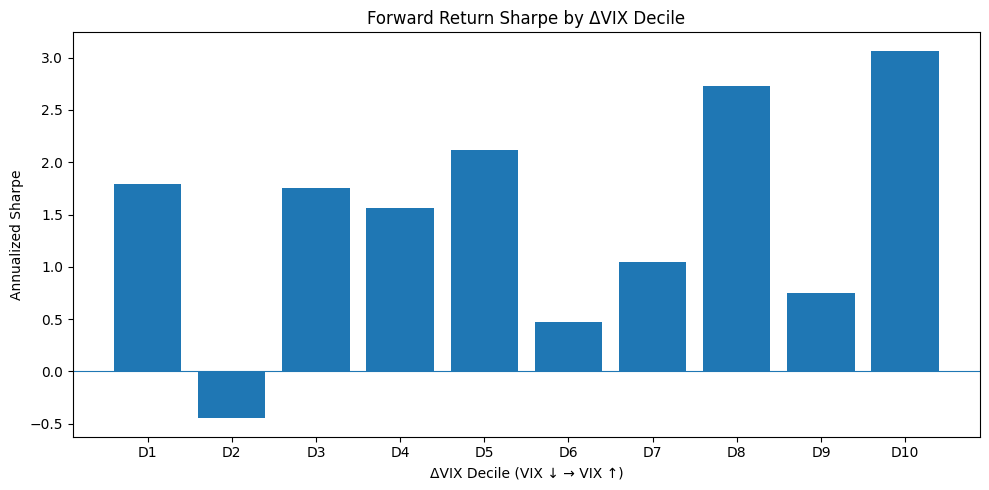

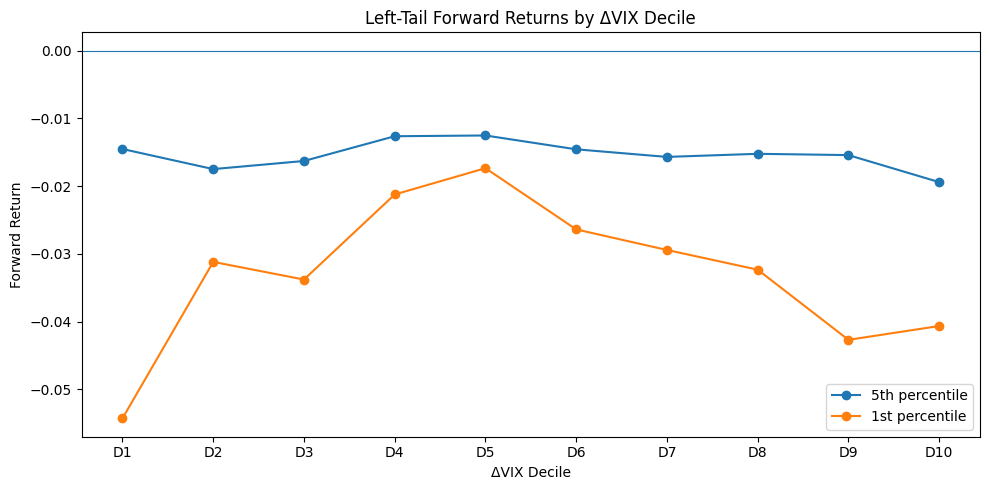

In [27]:
plot_df = dvix_decile_stats.to_pandas()
plot_df["decile"] = plot_df["dvix_decile"].astype(str)

plt.figure(figsize=(10, 5))
plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
plt.axhline(0, linewidth=0.8)
plt.title("Forward Return Sharpe by ΔVIX Decile")
plt.xlabel("ΔVIX Decile (VIX ↓ → VIX ↑)")
plt.ylabel("Annualized Sharpe")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
plt.axhline(0, linewidth=0.8)
plt.title("Left-Tail Forward Returns by ΔVIX Decile")
plt.xlabel("ΔVIX Decile")
plt.ylabel("Forward Return")
plt.legend()
plt.tight_layout()
plt.show()


Hard to get anything here.

### PCA Rotation and PC1 Variance Explained

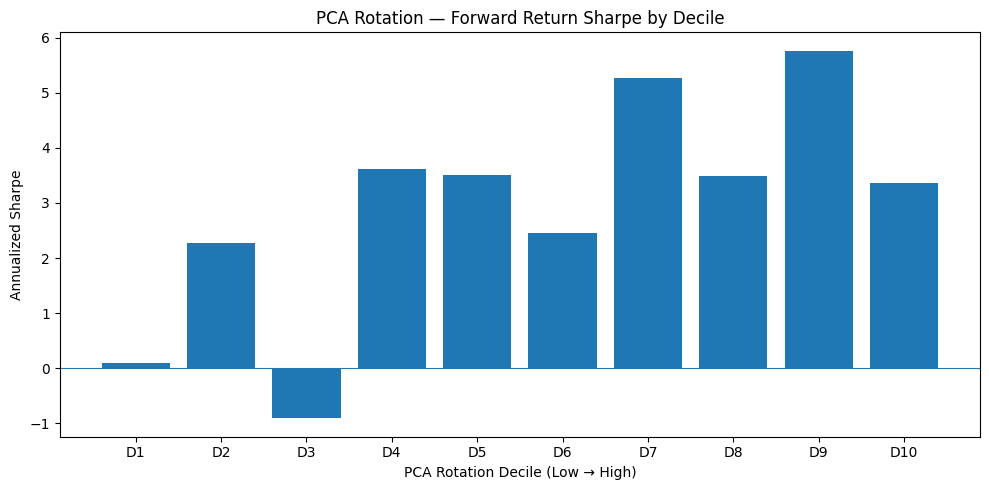

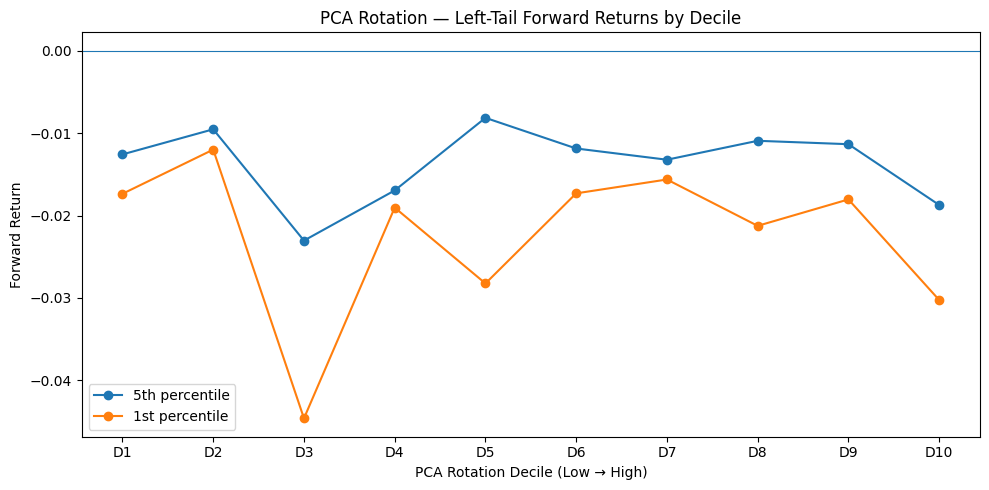

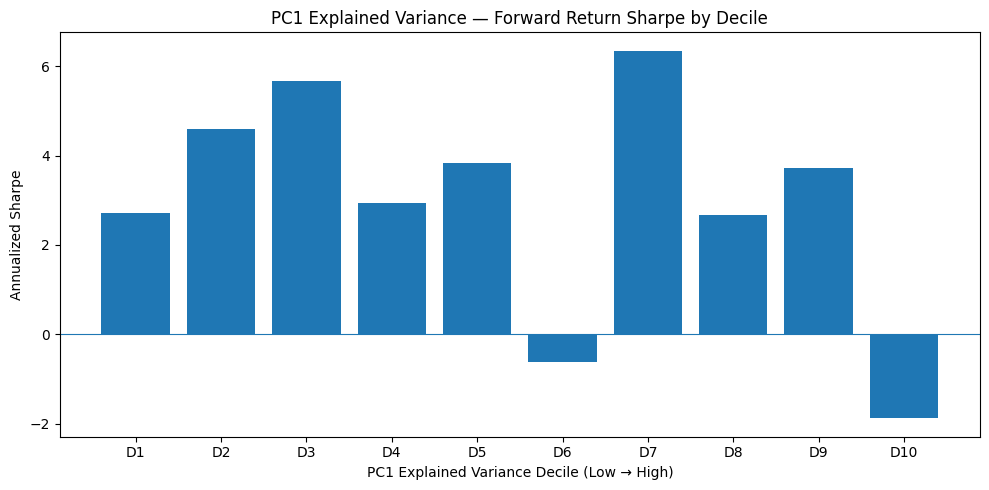

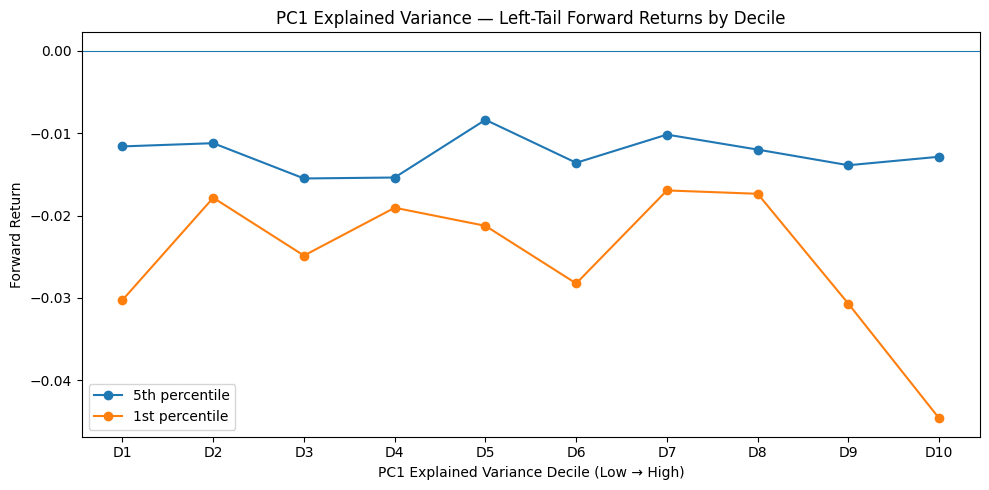

In [43]:
def decile_forward_stats(df_sig: pl.DataFrame, decile_col: str, title_prefix: str) -> pl.DataFrame:
    stats = (
        df_sig
        .group_by(decile_col)
        .agg([
            pl.len().alias("n_days"),
            pl.col("forward_ret").mean().alias("mean_daily"),
            pl.col("forward_ret").std().alias("std_daily"),
            pl.col("forward_ret").quantile(0.05).alias("p05"),
            pl.col("forward_ret").quantile(0.01).alias("p01"),
        ])
        .with_columns([
            (pl.col("mean_daily") / pl.col("std_daily") * np.sqrt(252)).alias("sharpe_ann"),
            (pl.col("mean_daily") * 252).alias("mean_ann"),
        ])
        .sort(decile_col)
    )

    # Plot
    plot_df = stats.to_pandas()
    plot_df["decile"] = plot_df[decile_col].astype(str)

    # A) Sharpe bar
    plt.figure(figsize=(10, 5))
    plt.bar(plot_df["decile"], plot_df["sharpe_ann"])
    plt.axhline(0, linewidth=0.8)
    plt.title(f"{title_prefix} — Forward Return Sharpe by Decile")
    plt.xlabel(f"{title_prefix} Decile (Low → High)")
    plt.ylabel("Annualized Sharpe")
    plt.tight_layout()
    plt.show()

    # B) Left tail lines
    plt.figure(figsize=(10, 5))
    plt.plot(plot_df["decile"], plot_df["p05"], marker="o", label="5th percentile")
    plt.plot(plot_df["decile"], plot_df["p01"], marker="o", label="1st percentile")
    plt.axhline(0, linewidth=0.8)
    plt.title(f"{title_prefix} — Left-Tail Forward Returns by Decile")
    plt.xlabel(f"{title_prefix} Decile (Low → High)")
    plt.ylabel("Forward Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return stats



daily_base = (
    daily_pnl
    .sort('tradingDay')
    .with_columns([
        pl.col("strategy_ret").shift(-1).alias("forward_ret"),
    ])
    .select(['tradingDay', "forward_ret"])
    .drop_nulls(["forward_ret"])
)


diag_tmp = diag.copy()
diag_tmp.index = pd.to_datetime(diag_tmp.index).date

pca_sig_pd = diag_tmp.reset_index().rename(columns={"index": 'tradingDay'})

keep_cols = ['tradingDay']
if "rotation" in pca_sig_pd.columns:
    keep_cols.append("rotation")
if "pc1_var" in pca_sig_pd.columns:
    keep_cols.append("pc1_var")

pca_sig = pl.from_pandas(pca_sig_pd[keep_cols])


df_sig_rot = (
    daily_base
    .join(pca_sig, on='tradingDay', how="left")
    .drop_nulls(["rotation", "forward_ret"])
    .with_columns(
        pl.col("rotation").qcut(10, labels=[f"D{i+1}" for i in range(10)]).alias("rot_decile")
    )
)
df_sig_rot.write_parquet(script_dir / 'data' / 'df_sig_rot.parquet')

rot_decile_stats = decile_forward_stats(
    df_sig_rot.select(['tradingDay', "rotation", "forward_ret", "rot_decile"]),
    decile_col="rot_decile",
    title_prefix="PCA Rotation"
)

rot_decile_stats



if "pc1_var" in df_sig_rot.columns:
    df_sig_pc1v = (
        daily_base
        .join(pca_sig, on='tradingDay', how="left")
        .drop_nulls(["pc1_var", "forward_ret"])
        .with_columns(
            pl.col("pc1_var").qcut(10, labels=[f"D{i+1}" for i in range(10)]).alias("pc1v_decile")
        )
    )

    pc1v_decile_stats = decile_forward_stats(
        df_sig_pc1v.select(['tradingDay', "pc1_var", "forward_ret", "pc1v_decile"]),
        decile_col="pc1v_decile",
        title_prefix="PC1 Explained Variance"
    )

    pc1v_decile_stats


* The Sharpe increases monotonically as you move into higher PCA rotation deciles, with a clear peak in the upper tail (D7–D9).
* Low-rotation regimes (D1–D3) are weak to outright bad.
* This is not noise:
    * The gradient is smooth
    * The separation is economically large
    * It aligns with how PCA-based hedges behave in practice

When the dominant volatility mode is stable, the carry extraction behaves closer to expectation and mean-reversion dominates.
When PC1 rotates quickly, relative-value assumptions break and the hedge no longer neutralizes the true shock direction.

When PC1 explains “too much,” the curve collapses into a single-factor trade and carry degenerates into a beta exposure.
When PC1 explains “too little,” the structure is unstable and noisy.

| Signal       | What it controls            | What it explains           |
| ------------ | --------------------------- | -------------------------- |
| PCA rotation | Stability of hedge geometry | When carry works at all    |
| PC1 variance | Dimensionality of risk      | When carry turns into beta |


Together:

* Rotation answers “is the hedge still meaningful?”
* PC1 variance answers “is this still a relative-value trade?”

### Return Dispersion Analysis

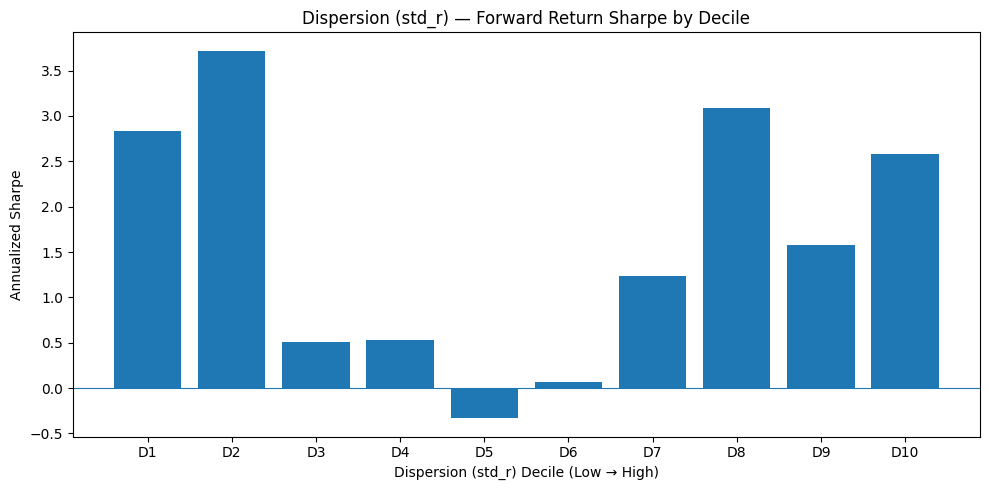

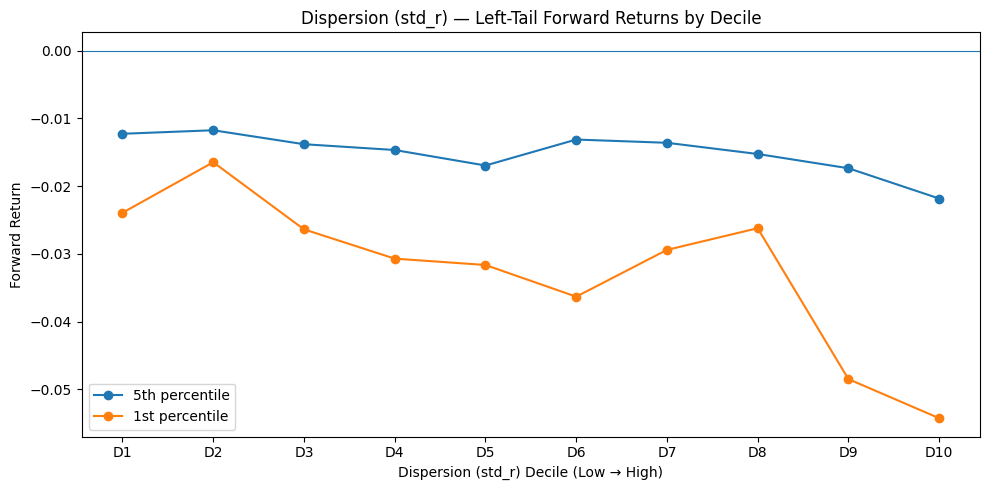

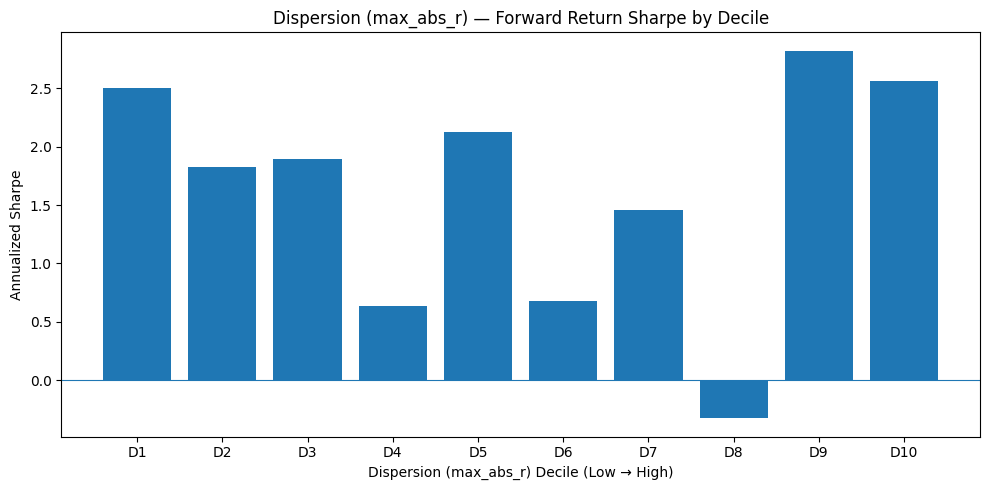

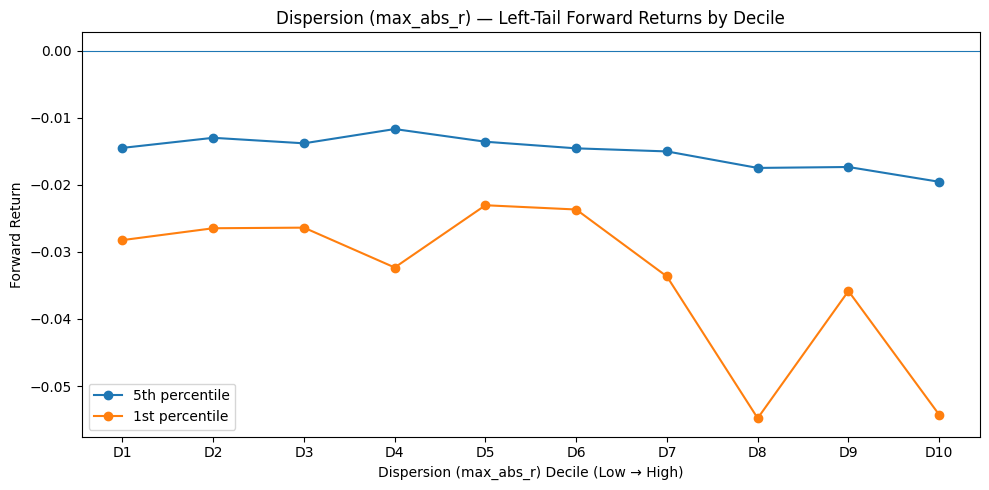

In [42]:
df_disp = daily_xs.select([COL_DATE] + [c for c in ["std_r", "max_abs_r"] if c in daily_xs.columns])

# Join to forward returns
df_sig_std = None
if "std_r" in df_disp.columns:
    df_sig_std = (
        daily_base
        .join(df_disp.select([COL_DATE, "std_r"]), on=COL_DATE, how="left")
        .drop_nulls(["std_r", "forward_ret"])
        .with_columns(
            pl.col("std_r").qcut(10, labels=[f"D{i+1}" for i in range(10)]).alias("std_r_decile")
        )
    )

    std_r_decile_stats = decile_forward_stats(
        df_sig_std.select([COL_DATE, "std_r", "forward_ret", "std_r_decile"]),
        decile_col="std_r_decile",
        title_prefix="Dispersion (std_r)"
    )

    std_r_decile_stats


df_sig_maxabs = None
if "max_abs_r" in df_disp.columns:
    df_sig_maxabs = (
        daily_base
        .join(df_disp.select([COL_DATE, "max_abs_r"]), on=COL_DATE, how="left")
        .drop_nulls(["max_abs_r", "forward_ret"])
        .with_columns(
            pl.col("max_abs_r").qcut(10, labels=[f"D{i+1}" for i in range(10)]).alias("maxabs_decile")
        )
    )

    maxabs_decile_stats = decile_forward_stats(
        df_sig_maxabs.select([COL_DATE, "max_abs_r", "forward_ret", "maxabs_decile"]),
        decile_col="maxabs_decile",
        title_prefix="Dispersion (max_abs_r)"
    )

    maxabs_decile_stats

When cross-sectional dispersion is low, the curve behaves as a coherent object and relative-value carry works.
When dispersion rises, the legs stop offsetting each other — the hedge degrades.

* std_r is a risk-off / risk veto signal
* Not a return maximizer by itself
| Signal           | What it measures           | What it controls    |
| ---------------- | -------------------------- | ------------------- |
| PCA rotation     | Stability of risk geometry | Whether hedge works |
| PC1 variance     | Dimensionality of risk     | Beta vs RV          |
| std_r dispersion | Cross-sectional noise      | Tail amplification  |
| max_abs_r        | Localized shocks           | Crash risk          |
